# TP Final Análisis de Series de Tiempo I

Docente: Camilo Argoty

Alumnos:

- Fabricio Lopretto (a1616)
- Agustina Quiros (a1711)
- Gonzalo Gabriel Fernandez (e1911)
- Cecilia Azul Villanueva (a1605)

2do Bimestre 2025

### Resumen

En esta notebook se analiza una serie temporal de precios diarios de Bitcoin (BTC/USD) con el objetivo de aplicar distintos modelos predictivos y evaluar su desempeño. El flujo de trabajo se organiza en las siguientes etapas:

1. **Carga y preparación de datos**:
   - Se carga un archivo Excel con datos históricos diarios de cotización de BTC.
   - Se convierte la columna `Fecha` al formato `datetime` y se ordenan los registros cronológicamente.
   - Se estandarizan los tipos de datos en columnas numéricas (`Cierre`, `Apertura`, `Máximo`, `Mínimo`, `Volumen`) para asegurar su correcto procesamiento.

2. **Limpieza de datos**:
   - Se identifican y revisan posibles valores faltantes.
   - Se realiza la conversión de separadores decimales en las columnas con valores numéricos.

3. **Visualización y análisis exploratorio**:
   - Se genera un análisis descriptivo inicial para comprender la evolución del precio de BTC a lo largo del tiempo.
   - Se visualizan tendencias generales y volatilidad en la serie.

4. **Modelado de series temporales**:
   - Se implementan modelos ARIMA y GARCH para capturar la estructura temporal y la volatilidad.
   - Se desarrolla una red neuronal LSTM para incorporar patrones secuenciales no lineales en la predicción.

5. **Evaluación de modelos**:
   - Se comparan las predicciones de los distintos modelos utilizando métricas de error.
   - Se visualiza el desempeño de los modelos en función de su capacidad predictiva sobre datos no vistos.

Este enfoque integral permite analizar la serie temporal de BTC desde múltiples perspectivas, combinando modelos estadísticos tradicionales con técnicas modernas de aprendizaje profundo.


In [1]:
# Instalación de librerías
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install statsmodels
!pip install arch
!pip install keras
!pip install openpyxl


[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag


[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [3]:
# Carpeta actual desde donde estás ejecutando la notebook
ruta_notebook = os.getcwd()

# Carpeta principal
menu_principal = os.path.abspath(os.path.join(ruta_notebook, '..'))

# Carpeta del archivo de datos
ruta_datos = 'datos/BTC_USD_ALL_20240601.xlsx'

# Ruta al archivo de datos
ruta_archivo = os.path.join(menu_principal, ruta_datos)

In [4]:
# Carga del DataFrame con los registros
df = pd.read_excel(ruta_archivo, sheet_name='daily')

In [5]:
# Visualiza informacion del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     5432 non-null   datetime64[ns]
 1   Cierre    5432 non-null   float64       
 2   Apertura  5432 non-null   float64       
 3   Maximo    5432 non-null   float64       
 4   Minimo    5432 non-null   float64       
 5   Volumen   5089 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 254.8 KB


*Fuente:* https://es.investing.com/crypto/bitcoin/historical-data

### Formato de datos

#### a) Fecha

In [6]:
# Convertir la columna Fecha a formato 'datetime'
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)

# Ordenar por fecha
df = df.sort_values('Fecha').reset_index(drop=True)

#### b) Apertura, cierre, máximo, mínimo y volumen

In [7]:
# Asegurar que las columnas numéricas sean 'float'
columnas_numericas = ['Cierre', 'Apertura', 'Maximo', 'Minimo', 'Volumen']
df[columnas_numericas] = df[columnas_numericas].replace(',', '.', regex=True).astype(float)

### Revisión de valores faltantes o nulos

In [8]:
print(df.isnull().sum())

Fecha         0
Cierre        0
Apertura      0
Maximo        0
Minimo        0
Volumen     343
dtype: int64


Observaciones:

La cantidad de valores faltantes de Volumen no llega a representar el 10% de los registros. Además, los valores faltantes se ubican en los primeros registros, donde el valor del BTC y su volumen de transacciones es despreciable frente a los valores posteriores. Debido a esto, se implementa un forzado a cero de dichos valores, para mantener la coherencia temporal.

Justificación:

I) El análisis de series de tiempo requiere datos continuos y ordenados cronológicamente. Eliminar filas podría provocar huecos temporales que distorsionan modelos como ARIMA, Prophet o LSTM.

II) Es importante notar que no se están modificando los precios (Apertura, Cierre, Máximo, Mínimo). Solo se está estimando el Volumen, que no es esencial para todos los modelos, pero puede ser útil como variable explicativa o para análisis adicionales.

III) Si se eliminaran los 343 registros con Volumen = NaN, se estaría reduciendo la muestra y posiblemente concentrándose el análisis en ciertos períodos, afectando la estacionalidad y otras características temporales del BTC.

In [9]:
# Tratamiento sobre valores faltantes de volumen
df['Volumen'] = df['Volumen'].fillna(0)

Lista de características utilizadas:

| Característica | Denominación                                             |
|----------------|----------------------------------------------------------|
| Fecha          | Fecha de operaciones                                     |
| Cierre         | Valor en USD de apertura del período (el día en curso)   |
| Apertura       | Valor en USD de apertura del período (el día en curso)   |
| Maximo         | Valor máximo en USD durante el período (el día en curso) |
| Minimo         | Valor mínimo en USD durante el período (el día en curso) |
| Volumen        | Valor total en USD de las transacciones del período (el día en curso) |

### Visualización del conjunto de datos

In [10]:
# Visualización de las primeras filas
df.head(10)

,Fecha,Cierre,Apertura,Maximo,Minimo,Volumen
0,2010-07-18,0.1,0.0,0.1,0.1,0.0
1,2010-07-19,0.1,0.1,0.1,0.1,0.0
2,2010-07-20,0.1,0.1,0.1,0.1,0.0
3,2010-07-21,0.1,0.1,0.1,0.1,0.0
4,2010-07-22,0.1,0.1,0.1,0.1,0.0
5,2010-07-23,0.1,0.1,0.1,0.1,0.0
6,2010-07-24,0.1,0.1,0.1,0.1,0.0
7,2010-07-25,0.1,0.1,0.1,0.1,0.0
8,2010-07-26,0.1,0.1,0.1,0.1,0.0
9,2010-07-27,0.1,0.1,0.1,0.1,0.0


In [11]:
df.tail(10)

,Fecha,Cierre,Apertura,Maximo,Minimo,Volumen
5422,2025-05-23,107313.4,111702.6,111778.7,106855.4,87570.0
5423,2025-05-24,107763.0,107313.5,109476.4,106904.5,52260.0
5424,2025-05-25,109021.1,107763.0,109203.4,106648.3,52490.0
5425,2025-05-26,109455.3,109014.9,110401.4,108694.0,48010.0
5426,2025-05-27,108944.0,109455.3,110718.7,107572.2,65020.0
5427,2025-05-28,107786.7,108905.7,109238.3,106804.9,51840.0
5428,2025-05-29,105600.0,107759.1,108896.7,105399.9,70020.0
5429,2025-05-30,103981.3,105598.8,106314.9,103693.9,71980.0
5430,2025-05-31,104598.0,103981.9,104888.4,103091.3,35800.0
5431,2025-06-01,105635.2,104598.0,105867.5,103768.6,33030.0


### Gráficos

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

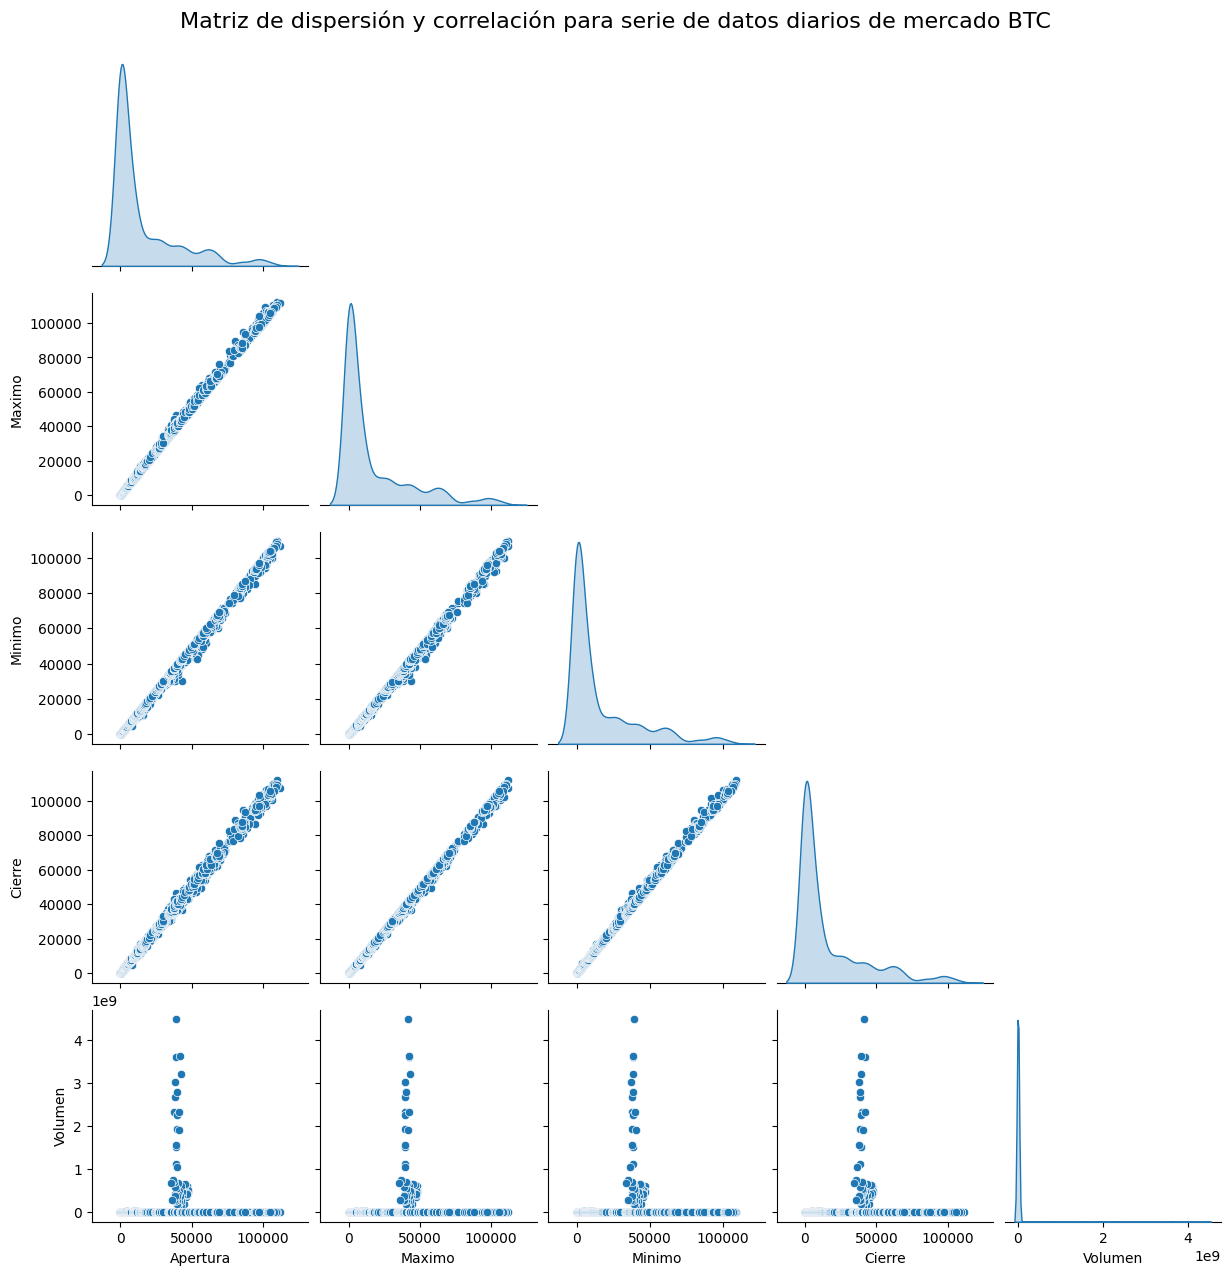

In [12]:
# Seleccionar las columnas numéricas para la correlación
columnas_a_plotear = ['Apertura', 'Maximo', 'Minimo', 'Cierre', 'Volumen']

# Crear la matriz de dispersión
sns.pairplot(df[columnas_a_plotear], diag_kind="kde", corner=True)

# Mostrar el gráfico
plt.suptitle("Matriz de dispersión y correlación para serie de datos diarios de mercado BTC", y=1.02, fontsize=16)
plt.show()

Observaciones:

Alta correlación lineal entre: Apertura, Cierre, Mínimo y Máximo. Además, se identificó un ligero aumento del Volumen con el aumento de Apertura, Cierre, Mínimo y Máximo.

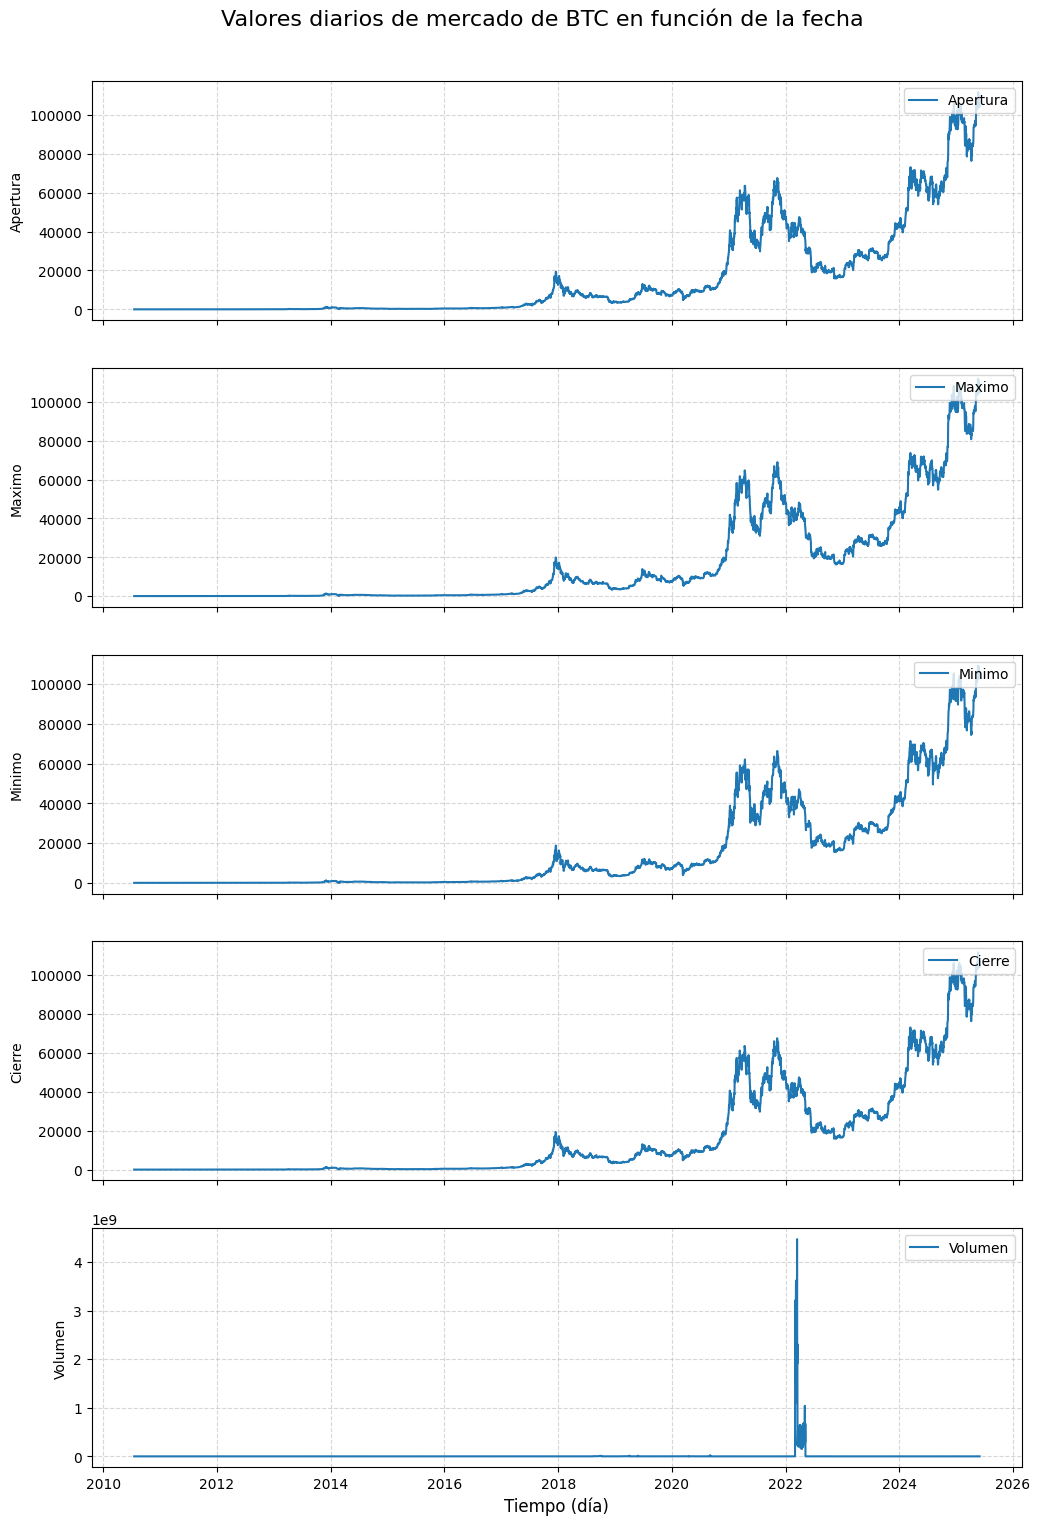

In [13]:
# Configurar las columnas para graficar y la figura
columnas_a_plotear = ['Apertura', 'Maximo', 'Minimo', 'Cierre', 'Volumen']
fig, axes = plt.subplots(len(columnas_a_plotear), 1, figsize=(12, 18), sharex=True)

# Graficar cada variable
for i, col in enumerate(columnas_a_plotear):
    axes[i].plot(df['Fecha'], df[col], label=col, linewidth=1.5)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Configurar el eje x compartido
axes[-1].set_xlabel('Tiempo (día)', fontsize=12)
fig.suptitle('Valores diarios de mercado de BTC en función de la fecha', fontsize=16, y=0.92)

# Ajustar diseño
plt.show()

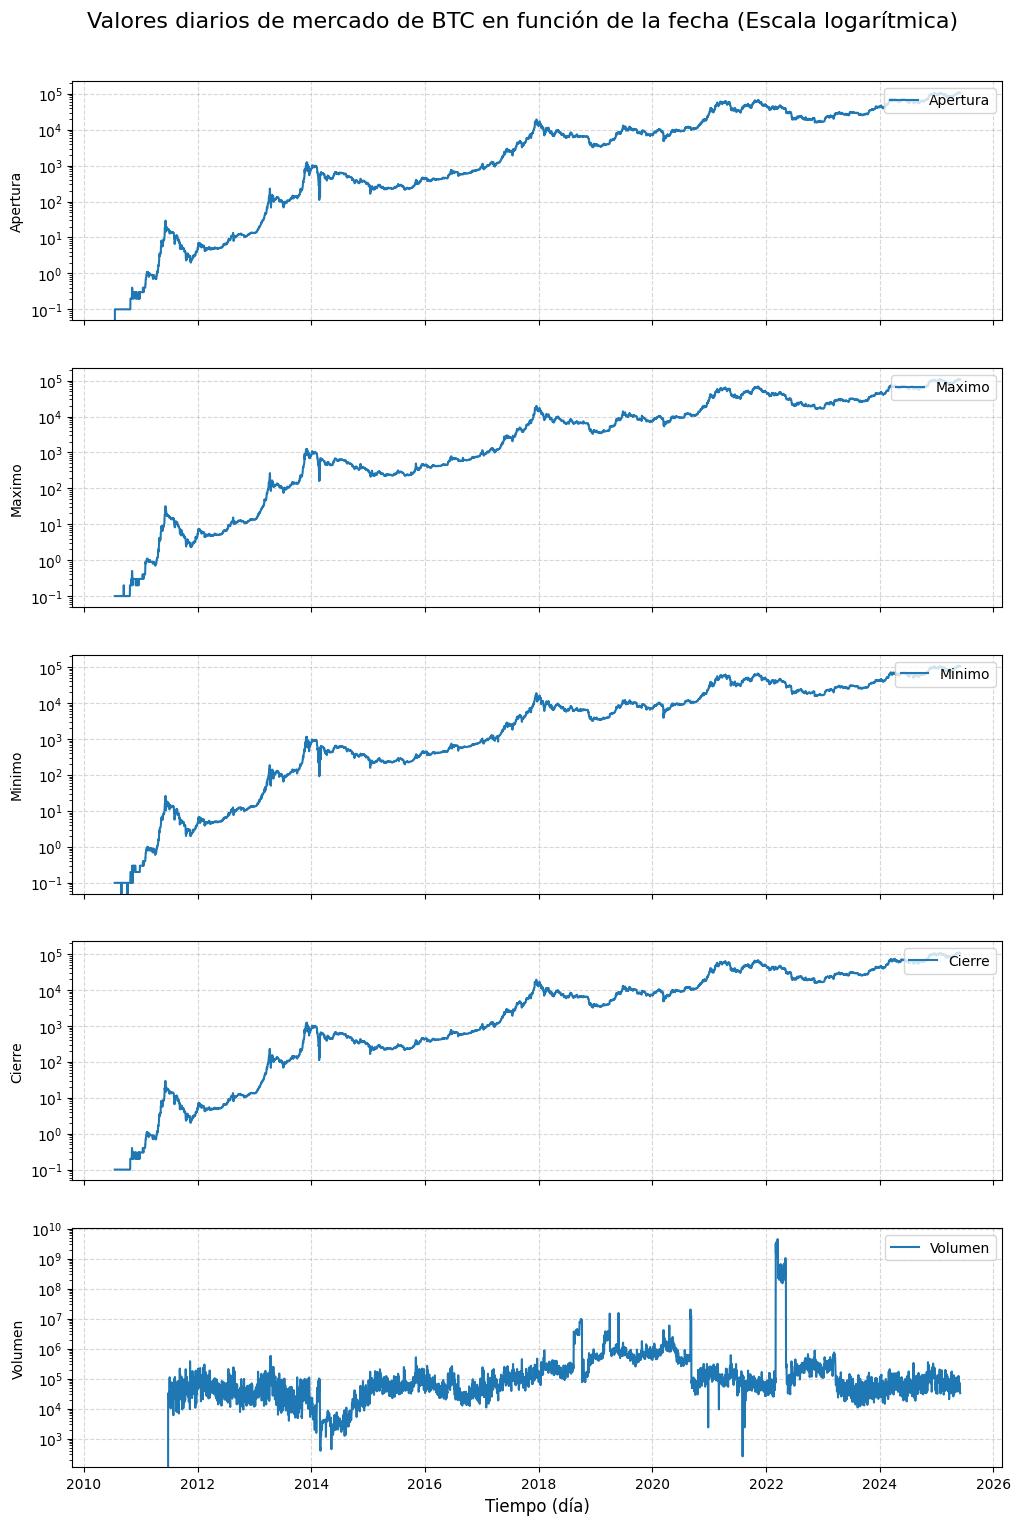

In [14]:
# Configurar las columnas para graficar y la figura
fig, axes = plt.subplots(len(columnas_a_plotear), 1, figsize=(12, 18), sharex=True)

# Graficar cada variable en escala logarítmica
for i, col in enumerate(columnas_a_plotear):
    axes[i].plot(df['Fecha'], df[col], label=col, linewidth=1.5)
    axes[i].set_yscale('log')  # Escala logarítmica
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Configurar el eje x compartido
axes[-1].set_xlabel('Tiempo (día)', fontsize=12)
fig.suptitle('Valores diarios de mercado de BTC en función de la fecha (Escala logarítmica)', fontsize=16, y=0.92)

# Ajustar diseño
plt.show()

*Observaciones:*

Alta variablidad en todas las caracterísiticas. Se identifica un aumento en el orden de magnitud de Apertura, Cierre, Máximo y Mínimo en períodos de aproximadamente 4 años.

- Análisis detallado a partir de 2022

In [15]:
def filter_df(df):
    df = df.copy()
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)  
    df = df.sort_values('Fecha')
    return df[df['Fecha'] >= '2022-01-01']


def graficar_precio_volumen(df_filtrado):
    sns.set(style="white") 

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    sns.lineplot(data=df_filtrado, x='Fecha', y='Cierre', label='Cierre', ax=ax1, color='blue', alpha=0.6)
    # sns.lineplot(data=df_filtrado, x='Fecha', y='Apertura', label='Apertura', ax=ax1, color='yellow', alpha=0.4)
    ax1.set_title('Evolución del Precio BTC a partir de 2022')
    ax1.set_ylabel('Precio (USD)')
    ax1.legend()
    
    sns.lineplot(data=df_filtrado, x='Fecha', y='Volumen', label='Volumen', ax=ax2, color='orange')
    ax2.set_title('Volumen de Transacciones BTC a partir de 2022')
    ax2.set_ylabel('Volumen')
    ax2.set_xlabel('Fecha')
    ax2.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def mostrar_top_volumen(df_filtrado, top_n=10):
    top = df_filtrado.sort_values('Volumen', ascending=False).head(top_n)
    print(f"\nTop {top_n} días con mayor volumen:")
    print(top[['Fecha', 'Volumen', 'Cierre', 'Apertura']])
    return top


def analizar_volumen(df):
    df_2022 = filter_df(df)
    
    graficar_precio_volumen(df_2022)

    mostrar_top_volumen(df_2022)

    return 

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

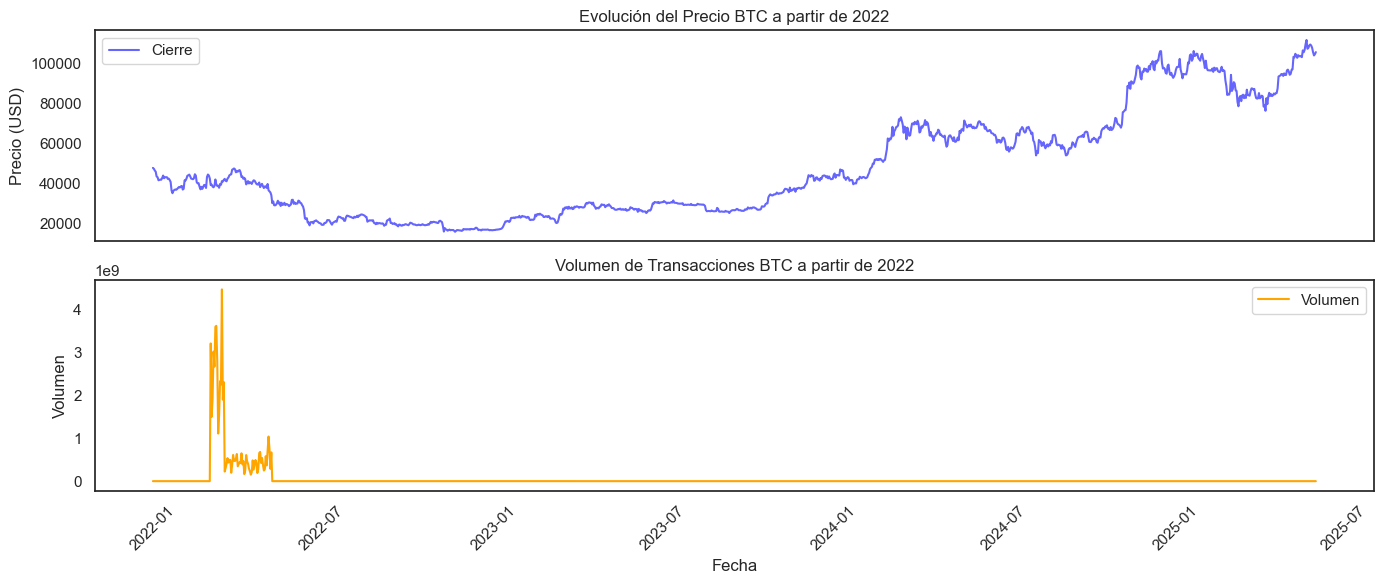


Top 10 días con mayor volumen:
          Fecha       Volumen   Cierre  Apertura
4259 2022-03-16  4.470000e+09  41118.7   39282.5
4253 2022-03-10  3.620000e+09  39416.3   41933.9
4252 2022-03-09  3.600000e+09  41929.0   38731.5
4247 2022-03-04  3.210000e+09  39142.7   42463.0
4250 2022-03-07  3.020000e+09  38024.8   38420.6
4254 2022-03-11  2.790000e+09  38730.2   39422.5
4251 2022-03-08  2.670000e+09  38744.8   38020.6
4257 2022-03-14  2.330000e+09  39671.1   37789.5
4261 2022-03-18  2.310000e+09  41767.8   40914.6
4258 2022-03-15  2.250000e+09  39285.7   39673.0


In [16]:
analizar_volumen(df)

Análisis

Resulta llamativo el aumento de volumen de BTC a partir de 2022. En los primeros meses, se observa un volumen diario muy superior al promedio histórico. Este tipo de picos suele indicar un evento extraordinario en el mercado. Sin embargo, no está acompañado de un cambio de precio proporcional, a diferencia de otros momentos donde grandes volúmenes coinciden con subidas o caídas abruptas de precio, aquí el precio no se disparó en la misma magnitud. Esto podría indicar acumulación o distribución silenciosa.

Hipótesis

1. Eventos importantes: 
- Puede haber habido algún anuncio fuerte, como nuevas reglas del gobierno (por ejemplo, China o Estados Unidos), o decisiones del banco central de EE. UU. (la FED).
- También es posible que alguna empresa importante haya hecho una compra o venta muy grande de Bitcoin.
- A veces, alguna noticia como un hackeo, una caída de una plataforma conocida (como pasó con FTX en 2022), puede causar movimientos bruscos.

2. Mucha actividad sin grandes cambios de precio:
 Es posible que en esas fechas se haya comprado y vendido mucho, pero sin que el precio cambie tanto. Esto pasa cuando hay mucha especulación.

4. Manipulación del mercado:
 En algunos casos, hay traders o bots que hacen compras y ventas para inflar el volumen y dar una falsa sensación de movimiento. Esto se llama “wash trading”.

Teniendo en cuenta las fechas que caen dentro del top de días con mayor volumen, se encontró una [fuente](https://swapzone.io/blog/bitcoin-spikes) que indica que el 16 de marzo de 2022 el BTC subió 5%  generando impacto en el volumen. 

### Operaciones adicionales

In [17]:
# Indexado por fecha
df.set_index('Fecha', inplace=True)

## Modelos

Los modelos utilizados son los siguientes (con algunas de sus características):

| Modelo    | Fortalezas                                                     | Limitaciones                                                             |
| --------- | -------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **ARIMA** | Modela patrones lineales, tendencia, estacionalidad.           | No captura volatilidad ni relaciones no lineales.                        |
| **ARCH**  | Captura bien la volatilidad (riesgo) en datos financieros.     | No predice directamente precios, sino varianza.                          |
| **LSTM**  | Modela relaciones complejas y no lineales a largo plazo.       | Requiere muchos datos, más tiempo de entrenamiento y puede sobreajustar. |
| **GBM**   | Modela la evolución aleatoria de una variable en el tiempo.    | No puede capturar eventos como crisis financieras o saltos repentinos.   |

La variable utilizada es el valor diario de **Cierre** operado en BTC.

En modelos basados en aprendizaje automático como LSTM conviene utilizar los datos escalados porque estos modelos son sensibles a la magnitud de los datos. Mientras que en modelos como ARIMA o ARCH no es necesario, dado que el primero trabaja con la diferencia entre valores (y por tanto ya "normaliza"), y el segundo modela la varianza condicional (volatilidad real) y escalar afectaría su interpretación. El modelo GBM es útil como primer modelo por su elegancia matemática y facilidad de interpretación. Pero no captura muchas características reales de los mercados financieros como *shocks* bruscos. Además supone que los retornos son independientes, cuando en realidad pueden tener correlación o memoria.

In [18]:
# Define la serie utilizada
serie_cierre = df['Cierre']

In [19]:
# Visualización de la serie de Cierre
print(serie_cierre)

Fecha
2010-07-18         0.1
2010-07-19         0.1
2010-07-20         0.1
2010-07-21         0.1
2010-07-22         0.1
                ...   
2025-05-28    107786.7
2025-05-29    105600.0
2025-05-30    103981.3
2025-05-31    104598.0
2025-06-01    105635.2
Name: Cierre, Length: 5432, dtype: float64


### ARIMA (AutoRegressive Integrated Moving Average)

Los parámetros utilizados en el planteo de este modelo son:
-	p = 5 (cantidad de términos autoregresivos).
-	d = 1 (números de diferencias aplicadas).
-	q = 0 (número del término de media móvil).

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Evaluación del modelo ARIMA:
MAE  (Error Absoluto Medio):       900.95
MSE  (Error Cuadrático Medio):     2117713.47
RMSE (Raíz del ECM):               1455.24


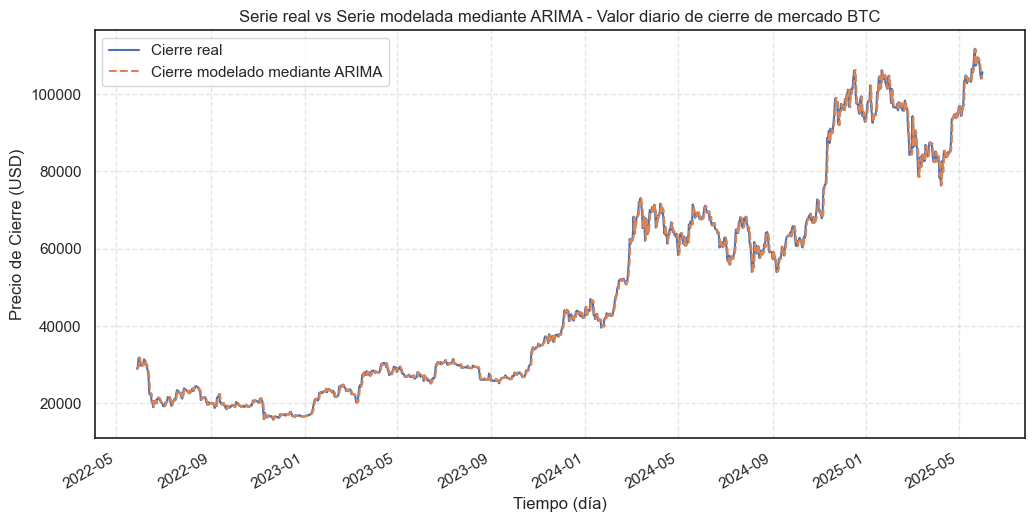

In [20]:
# Entrenamiento del modelo ARIMA
modelo_arima_cierre = ARIMA(serie_cierre, order=(5, 1, 0))
modelo_arima_cierre_fit = modelo_arima_cierre.fit()

# Predicción sobre las últimas 1100 fechas
start_idx = serie_cierre.index[-1100]
end_idx = serie_cierre.index[-1]
predicciones_arima_cierre = modelo_arima_cierre_fit.predict(start=start_idx, end=end_idx, typ='levels')

# Serie real para ese mismo intervalo
serie_real = serie_cierre.loc[start_idx:end_idx]

# Evaluación del modelo
mae = mean_absolute_error(serie_real, predicciones_arima_cierre)
mse = mean_squared_error(serie_real, predicciones_arima_cierre)
rmse = np.sqrt(mse)

print("Evaluación del modelo ARIMA:")
print(f"MAE  (Error Absoluto Medio):       {mae:.2f}")
print(f"MSE  (Error Cuadrático Medio):     {mse:.2f}")
print(f"RMSE (Raíz del ECM):               {rmse:.2f}")

# Visualización
plt.figure(figsize=(12, 6))
serie_real.plot(label='Cierre real')
predicciones_arima_cierre.plot(label='Cierre modelado mediante ARIMA', linestyle='--')
plt.legend()
plt.title('Serie real vs Serie modelada mediante ARIMA - Valor diario de cierre de mercado BTC')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Observaciones: 

- La serie modelada (naranja) sigue de manera bastante fiel a la serie real, especialmente en las oscilaciones de corto plazo.
- Hay muy poco rezago o desviación, lo cual indica que el modelo logra un buen ajuste en el conjunto de entrenamiento. Esto sugiere que la calidad del modelo en términos de ajuste histórico es buena.

Aunque el modelo tiene muy buen poder de ajuste en el histórico, este rendimiento no necesariamnte se transfiere al poder predictivo.

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


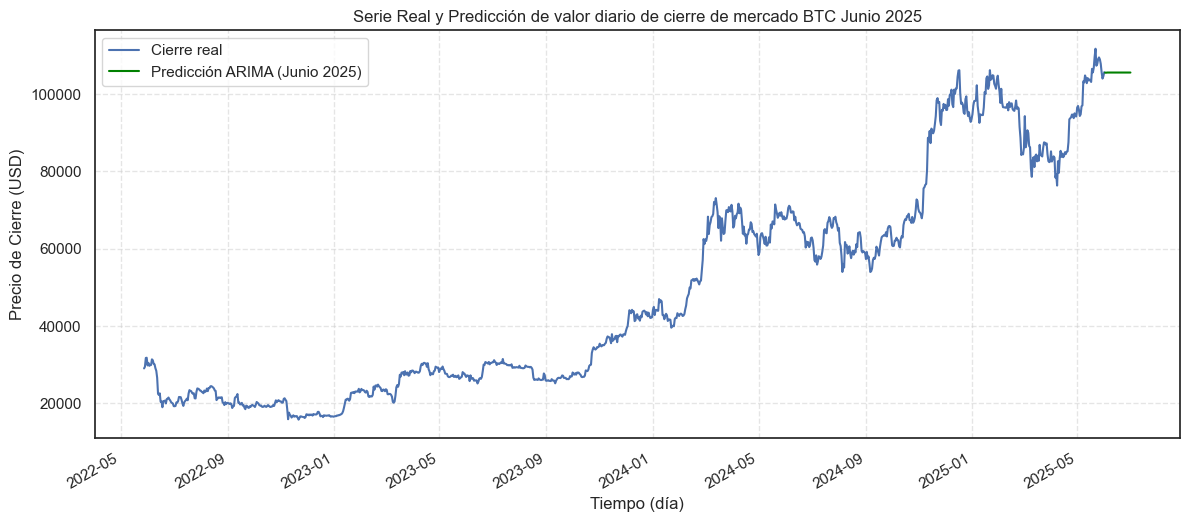

In [21]:
# Predicción a futuro: 30 días
n_dias_futuro = 30
predicciones_futuras = modelo_arima_cierre_fit.forecast(steps=n_dias_futuro)

# Crear nuevo índice de fechas futuras
ultima_fecha = serie_cierre.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=n_dias_futuro, freq='D')
predicciones_futuras.index = fechas_futuras

# Visualización
plt.figure(figsize=(14, 6))
serie_cierre[-1100:].plot(label='Cierre real')
predicciones_futuras.plot(label='Predicción ARIMA (Junio 2025)', linestyle='-', color='green')
plt.legend()
plt.title('Serie Real y Predicción de valor diario de cierre de mercado BTC Junio 2025')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Observaciones:

- El modelo ha sido entrenado con un volumen significativo de datos (últimos 1100 días), lo cual es positivo para capturar patrones temporales.
- La predicción del modelo para junio 2025 muestra un comportamiento casi constante o con muy baja variabilidad.
- No se observa una continuación clara de la tendencia alcista que se ve en los últimos meses previos a junio.

El modelo ARIMA muestra limitaciones para predecir movimientos más complejos o de alta volatilidad, como los que son comunes en criptomonedas como el BTC. Es probable que el componente autorregresivo y de media móvil esté suavizando demasiado las oscilaciones esperadas, lo cual lleva a una predicción bastante plana.

### ARCH (AutoRegressive Conditional Heteroskedasticity)

Evaluación del modelo ARCH(1):
MAE  (Error Absoluto Medio):      3.8629
MSE  (Error Cuadrático Medio):    32.7355
RMSE (Raíz del Error Cuadrático): 5.7215


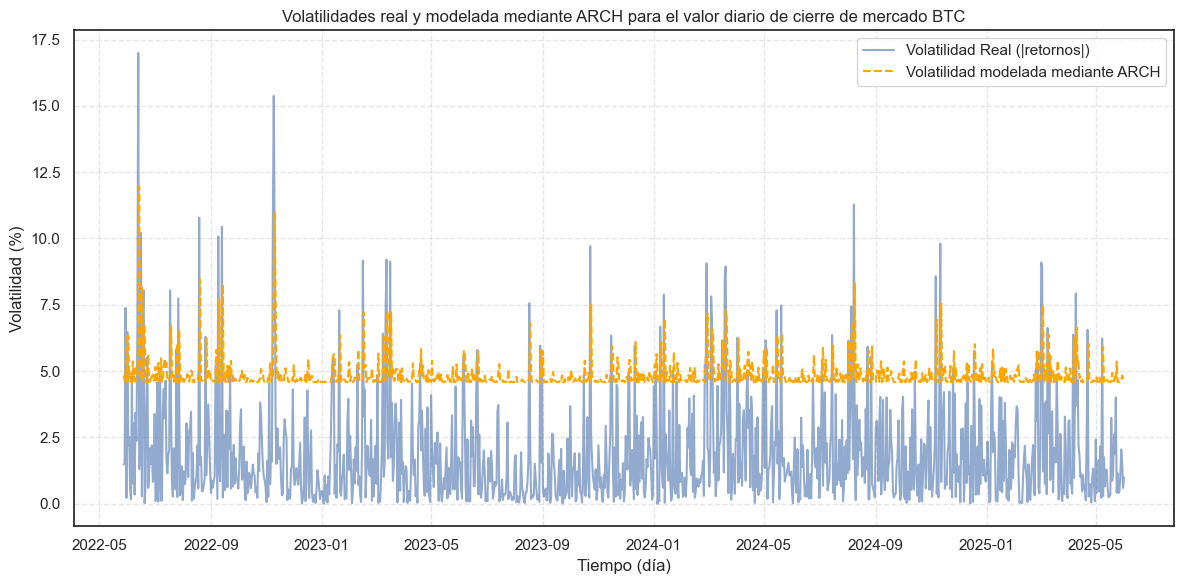

In [22]:
# Utilización de los retornos logarítmicos
retornos_cierre = 100 * np.log(serie_cierre / serie_cierre.shift(1)).dropna()

# Entrenamiento modelo ARCH (orden 1)
modelo_arch_cierre = arch_model(retornos_cierre, vol='ARCH', p=1)
modelo_arch_cierre_fit = modelo_arch_cierre.fit(disp='off')

# Predicción de la varianza condicional
volatilidad_predicha_cierre = modelo_arch_cierre_fit.conditional_volatility

# Calcular la "volatilidad real" como valor absoluto del retorno (aproximación)
volatilidad_real_cierre = np.abs(retornos_cierre)

# Alineación de índices (por si acaso)
volatilidad_predicha_cierre = volatilidad_predicha_cierre.loc[volatilidad_real_cierre.index]

# Cálculo de métricas de evaluación
mae = mean_absolute_error(volatilidad_real_cierre, volatilidad_predicha_cierre)
mse = mean_squared_error(volatilidad_real_cierre, volatilidad_predicha_cierre)
rmse = np.sqrt(mse)

print("Evaluación del modelo ARCH(1):")
print(f"MAE  (Error Absoluto Medio):      {mae:.4f}")
print(f"MSE  (Error Cuadrático Medio):    {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático): {rmse:.4f}")

# Seleccionar últimos 1100 días
vol_real_ultimos = volatilidad_real_cierre[-1100:]
vol_estim_ultimos = volatilidad_predicha_cierre[-1100:]

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(vol_real_ultimos.index, vol_real_ultimos, label='Volatilidad Real (|retornos|)', alpha=0.6)
plt.plot(vol_estim_ultimos.index, vol_estim_ultimos, label='Volatilidad modelada mediante ARCH', linestyle='--', color='orange')
plt.title('Volatilidades real y modelada mediante ARCH para el valor diario de cierre de mercado BTC')
plt.legend()
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Volatilidad (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observaciones:

Se observan *clusters* de volatilidad típicos en BTC, con picos pronunciados (por ejemplo en mediados de 2022) y períodos de calma relativa (por ejemplo 2023). En cuanto al ajuste del modelo, la línea de volatilidad modelada mediante ARCH sigue razonablemente bien la tendencia de la volatilidad real, especialmente en capturar los picos. Sin embargo, hay discrepancias dado que tiende a subestimar al amplitud de la volatilidad. Es posible que el modelo pueda mejorarse incorporando componentes asimétricos (propios de GARCH) para capturar efectos de mayor volatilidad tras caídas bruscas.

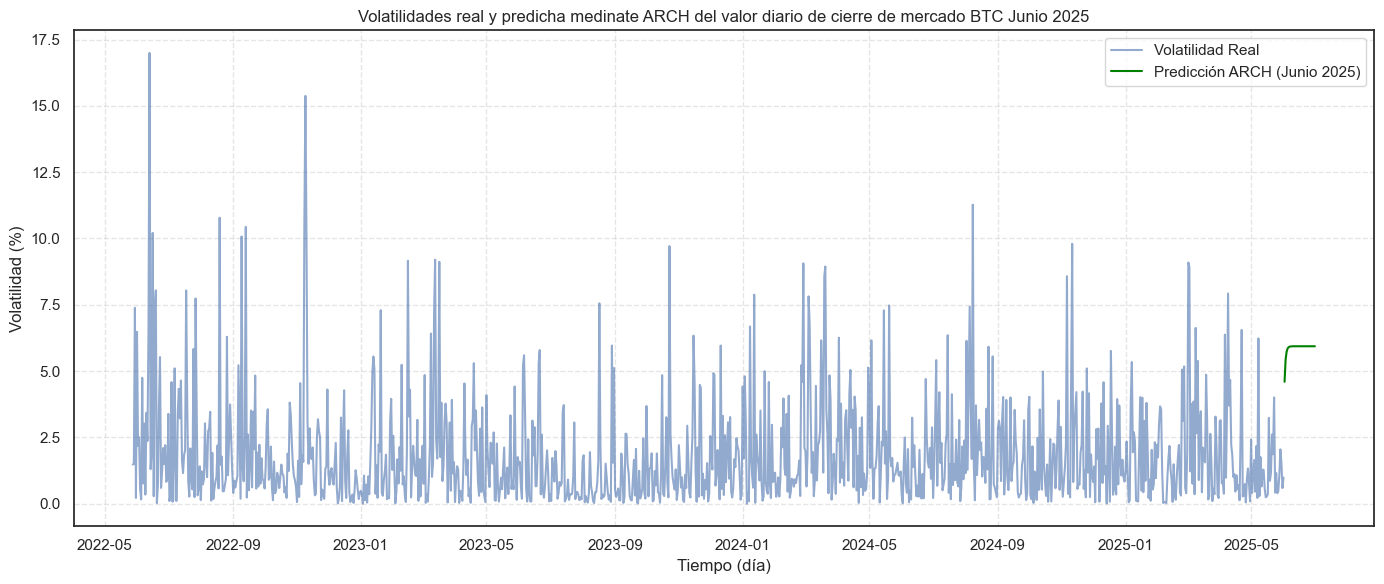

In [23]:
# Pronóstico de 30 días hacia adelante
forecast = modelo_arch_cierre_fit.forecast(horizon=30)

# Extraemos solo la última fila de predicciones
varianza_predicha = forecast.variance.iloc[-1]
volatilidad_predicha_futuro = np.sqrt(varianza_predicha)  # Raíz cuadrada de la varianza = desviación estándar

# Creamos un índice de fechas futuras
ultima_fecha = df.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=30, freq='D')

# Serie de predicciones
volatilidad_predicha_futuro.index = fechas_futuras

# Visualización
plt.figure(figsize=(14, 6))
plt.plot(volatilidad_real_cierre[-1100:], label='Volatilidad Real', alpha=0.6)
plt.plot(volatilidad_predicha_futuro, label='Predicción ARCH (Junio 2025)', linestyle='-', color='green')
plt.title('Volatilidades real y predicha medinate ARCH del valor diario de cierre de mercado BTC Junio 2025')
plt.legend()
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Volatilidad (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observaciones:

El modelo predice un nivel de volatilidad moderado para junio 2025, pero es crucial contrastarlo con el contexto del mercado que queda por fuera del modelo (por ejemplo noticias regulatorias, flujos de ETFs, actividad institucional). La proyección con este modelo sugiere que el mercado no anticipa eventos extremos, aunque BTC es propenso a shocks imprevistos. Esto hace que el modelo no sea confiable.

### LSTM (Long Short-Term Memory - Red Neuronal)

Debido a la volatilidad significativa en los datos históricos del BTC es conveniente utilizar el RobustScaler.

El precio del BTC puede aumentar o reducirse ampliamente en poco tiempo, esto genera precios y volúmenes muy altos o muy bajos. Los mismos pueden generarse por eventos mediáticos, regulaciones, hackeos, etc.

El RobustScaler no se deja influenciar por outliers, ya que usa la mediana y el rango intercuartílico (IQR) para escalar:

$$
X_{\text{scaled}} = \frac{X - \text{mediana}}{\text{IQR}}
$$

Además, es útil en el caso de variables con distribuciones no normales: Los precios y volúmenes del BTC suelen tener colas largas y asimetría (no tienen distribución gaussiana).

En este caso, la red cuenta con una ventana deslizante de n_steps días de precios pasados y el precio del día siguiente. Además, tiene por entrada en forma de [samples, timesteps, features].

Luego, la primera capa es del tipo LSTM con 50 celdas de memoria y función de activación 'tanh'. Esta capa devuelve sólo la última salida de la secuencia. A continuación, una capa totalmente conectada con una sola neurona de salida, que predice el valor del precio de cierre para el día siguiente. Por último, cuenta con optimizador adam con tasa de aprendizaje de 0.001, función de pérdida MSE y 20 épocas con batches de 32 muestras.

In [24]:
# Toma la serie como vector
serie_cierre_v2 = df[['Cierre']].values

# Escalar con RobustScaler
scaler = RobustScaler()
serie_cierre_scaled = scaler.fit_transform(serie_cierre_v2)

Epoch 1/20


c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0717
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 12/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 13/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 15/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011


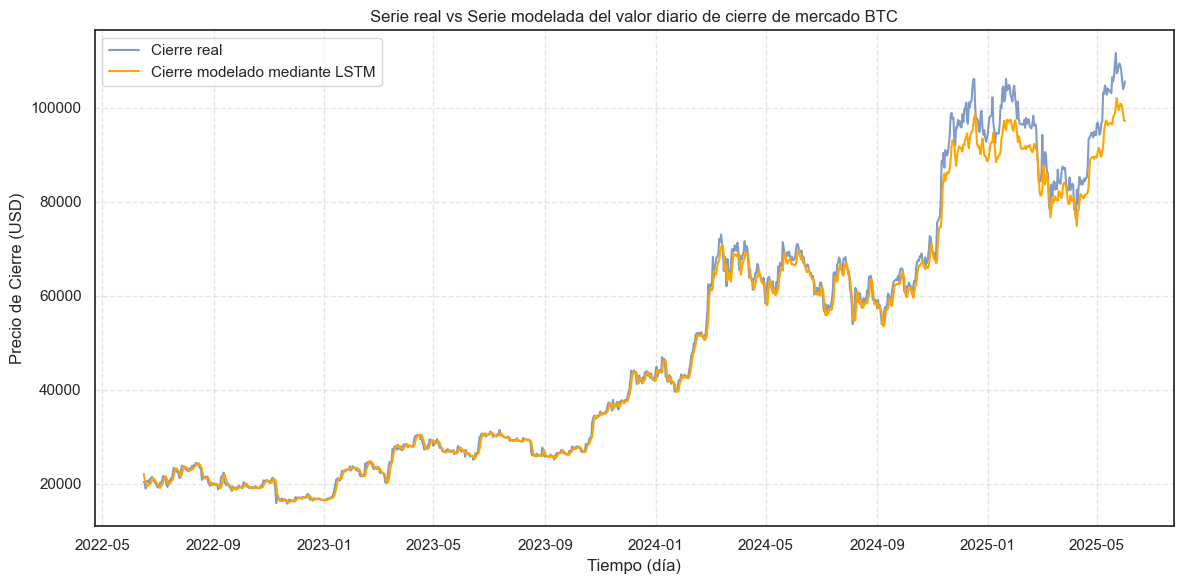

In [25]:
# Crear secuencias para LSTM
def crear_secuencias(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 30
X, y = crear_secuencias(serie_cierre_scaled, n_steps)

# Dividir en entrenamiento y testeo (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Redimensionar entrada para LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Modelo LSTM
modelo = Sequential()
modelo.add(LSTM(units=50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)))
modelo.add(Dense(1))
modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entrenamiento
modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predicciones
y_pred = modelo.predict(X_test)

# Desescalar predicciones y valores reales
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluación del modelo
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print("Evaluación del modelo LSTM:")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"MSE  (Error Cuadrático Medio): {mse:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")

# Crear un rango de fechas para graficar
fechas_test = df.index[n_steps + split:]

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(fechas_test, y_test_inv, label='Cierre real', alpha=0.7)
plt.plot(fechas_test, y_pred_inv, label='Cierre modelado mediante LSTM', color='orange')
plt.title('Serie real vs Serie modelada del valor diario de cierre de mercado BTC')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Observaciones: 

El modelo LSTM sigue razonablemente bien la dirección general (alcista/bajista) de los precios reales, especialmente en períodos de tendencia sostenida (por ejemplo subidas graduales o correcciones prolongadas). Si bien al principio del período mostrado el modelo tiende sobrestimar el valor de mercado, hacia el final esto se revierte mostrando una subestimación. Por otro lado, se nota un ligero delay en las predicciones, típico de LSTMs. Por ejemplo, en picos o valles abruptos, la predicción reacciona con un desfase. Esto sugiere que el modelo prioriza patrones históricos sobre cambios bruscos.

El modelo no captura bien los picos repentinos. Esto era esperable, ya que las LSTMs tienden a promediar la volatilidad. Una posible causa es la falta de variables como el volumen, noticias o insuficiente complejidad del modelo. Además, las predicciones parecen mantenerse dentro de un rango "seguro", evitando extrapolar valores extremos (por ejemplo tiende a no superar los USD$100.000 incluso si los datos reales lo hicieran).

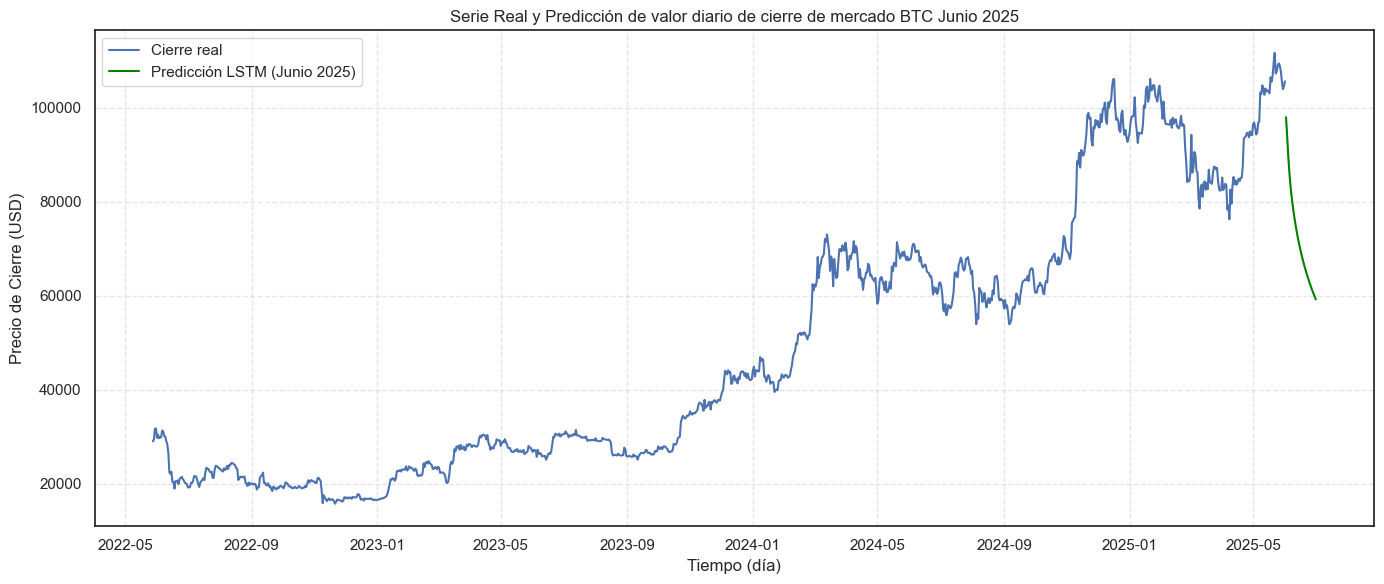

In [26]:
# Tomar los últimos 1100 valores reales para la predicción futura
valores_reales_futuros = serie_cierre_scaled[-1100:].tolist()

predicciones_futuras = []

for _ in range(30):
    entrada = np.array(valores_reales_futuros[-n_steps:]).reshape((1, n_steps, 1))
    pred = modelo.predict(entrada, verbose=0)
    valores_reales_futuros.append(pred[0])  # Agregamos la predicción a la secuencia extendida
    predicciones_futuras.append(pred[0])

# Invertimos el escalado
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

# Crear índice de fechas para los próximos 30 días
ultima_fecha = df.index[-1]
fechas_futuras = [ultima_fecha + timedelta(days=i+1) for i in range(30)]

# Visualizar los últimos 1100 reales + predicciones
plt.figure(figsize=(14, 6))
plt.plot(df.index[-1100:], serie_cierre_v2[-1100:], label='Cierre real')
plt.plot(fechas_futuras, predicciones_futuras_inv, color='green', label='Predicción LSTM (Junio 2025)')
plt.title('Serie Real y Predicción de valor diario de cierre de mercado BTC Junio 2025')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Observaciones:

En la proyección para junio de 2025, el modelo muestra una tendencia claramente bajista, pero sin sobresaltos. Esto último podría deberse a que las LSTMs suelen ser cautas en predicciones *multi-step*. Además, se identifica la falta de eventos imprevistos como *shocks* externos (por ejemplo regulaciones, flujos por ETFs, etc). No se descarta la necesidad de más capas o neuronas para aprender patrones complejos.

Siguiendo en esta línea, el modelo LSTM podría estar sobreponderando fases anteriores donde máximos históricos fueron seguidos de caídas. Si los datos de entrenamiento incluyen más ejemplos de *crash* que de *rallies* sostenidos, el modelo aprenderá a ser pesimista.

El modelo LSTM aprende bien la tendencia histórica pero falla en predecir volatilidad aguda, típica de BTC. Es útil para escenarios conservadores, pero no para *trading* de alta frecuencia o eventos disruptivos.

### Modelo Browiano Geométrico (Proceso de Wiener)

Es un proceso estocástico fundamental en la teoría de series de tiempo continuas. Describe la evolución aleatoria de una variable a lo largo del tiempo y se utiliza en múltiples disciplinas como física, biología, finanzas y estadística.

**Definición**

Un movimiento browniano estándar $B(t)$, definido para $t \geq 0$, cumple las siguientes propiedades:

Condición inicial: $B(0) = 0$

Incrementos independientes: $B(t_2) - B(t_1) \text{ es independiente de } B(t_4) - B(t_3) \quad \text{si } [t_1, t_2] \cap [t_3, t_4] = \emptyset$

Incrementos normales y estacionarios: $B(t + s) - B(t) \sim \mathcal{N}(0, s)$

Trayectorias continuas: $t \mapsto B(t) \text{ es continua con probabilidad 1}$

Nota: Aunque las trayectorias son continuas, no son diferenciables en ningún punto.

**Propiedades Importantes**

- Distribución marginal: $B(t) \sim \mathcal{N}(0, t)$

- Varianza lineal en el tiempo: $\text{Var}[B(t)] = t$

- Estacionariedad de los incrementos: La distribución del cambio depende solo del tamaño del intervalo, no del tiempo absoluto.

**Generalización**: Movimiento Browniano con Deriva y Volatilidad

Una forma más general es: $X(t) = \mu t + \sigma B(t)$

Donde:
- $\mu$: deriva (tendencia determinista),
- $\sigma$: volatilidad (escala de aleatoriedad),
- $B(t)$: movimiento browniano estándar.

Luego, usando la inversa del log-precio: $BTC(t)=BTC(0)⋅e^{X(t)}$

En este trabajo se utilizan 50 simulaciones para calcular el valor medio modelado.

Evaluación del modelo GBM (Promedio de 50 trayectorias):
MAE : 15704.31
MSE: 794254072.06
RMSE: 28182.51


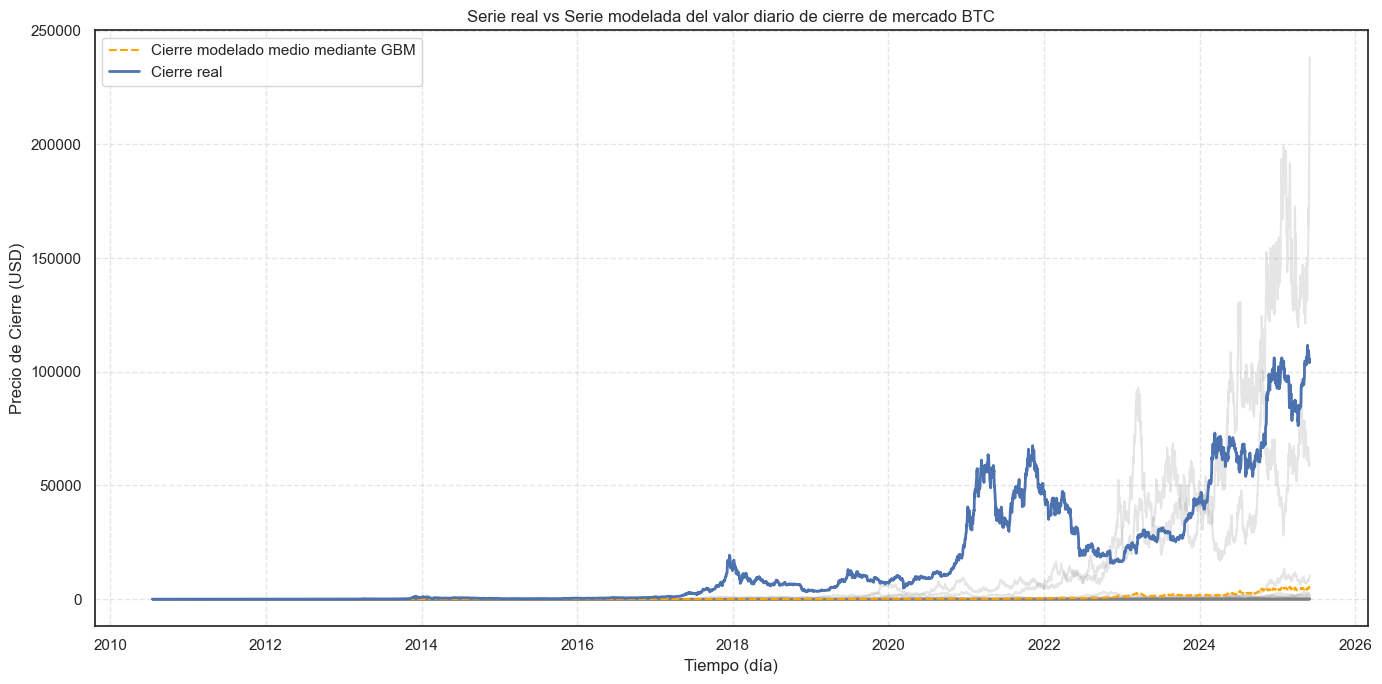

In [27]:
# Asegurar reproducibilidad
np.random.seed(42)

# Convertimos la serie a numpy array y tomamos log-retornos
log_returns = np.log(serie_cierre / serie_cierre.shift(1)).dropna()

# Estimamos parámetros del GBM
mu = log_returns.mean()  # drift
sigma = log_returns.std()  # volatilidad

# Cantidad de simulaciones
num_simulaciones = 50
N = len(serie_cierre) - 1
dt = 1
S0 = serie_cierre.iloc[0]
t = np.linspace(0, N * dt, N)

# Matriz para guardar simulaciones
simulaciones = np.zeros((num_simulaciones, N + 1))
simulaciones[:, 0] = S0

for i in range(num_simulaciones):
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    simulaciones[i, 1:] = S_t

# Crear DataFrame con fechas como índice
fechas = serie_cierre.index
df_simulaciones = pd.DataFrame(simulaciones.T, index=fechas)

# Calcular promedio de las simulaciones
promedio_simulado = df_simulaciones.mean(axis=1)

# Serie real para comparar (alineamos con la simulación, empezando desde el mismo día)
serie_real_alineada = serie_cierre

# Métricas
mae = mean_absolute_error(serie_real_alineada, promedio_simulado)
mse = mean_squared_error(serie_real_alineada, promedio_simulado)
rmse = np.sqrt(mse)

# Imprimir métricas
print(f"Evaluación del modelo GBM (Promedio de {num_simulaciones} trayectorias):")
print(f"MAE : {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualización
plt.figure(figsize=(14,7))
# Trazo de las simulaciones
for i in range(num_simulaciones):
    plt.plot(fechas, df_simulaciones.iloc[:, i], color='gray', alpha=0.2)
# Trazo del promedio de simulaciones
plt.plot(fechas, promedio_simulado, label='Cierre modelado medio mediante GBM', color='orange', linestyle='--')
# Trazo real
plt.plot(serie_cierre, label='Cierre real', linewidth=2)
plt.title('Serie real vs Serie modelada del valor diario de cierre de mercado BTC')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Observaciones:

El modelado medio mediante GBM parece seguir la tendencia alcista histórica de BTC, pero con una volatilidad muy suavizada. La serie real muestra fluctuaciones más abruptas que el modelado medio no captura. Además, el modelado medio no reproduce bien eventos extremos: La serie real sugiere ciclos de corrección tras subidas bruscas, algo que el GBM medio ignora (asume crecimiento exponencial continuo). El modelado medio mediante GBM parece ser útil para proyectar tendencias generales, pero falla en riesgos extremos y ciclos de mercado, críticos para estrategias de inversión reales. No obstante, en líneas grises se muestran las 50 simulaciones utilizadas. Si bien la mayoría provoca un promedio bajo, existen simulaciones que se ajustan mejor a los valores observados en la serie real.

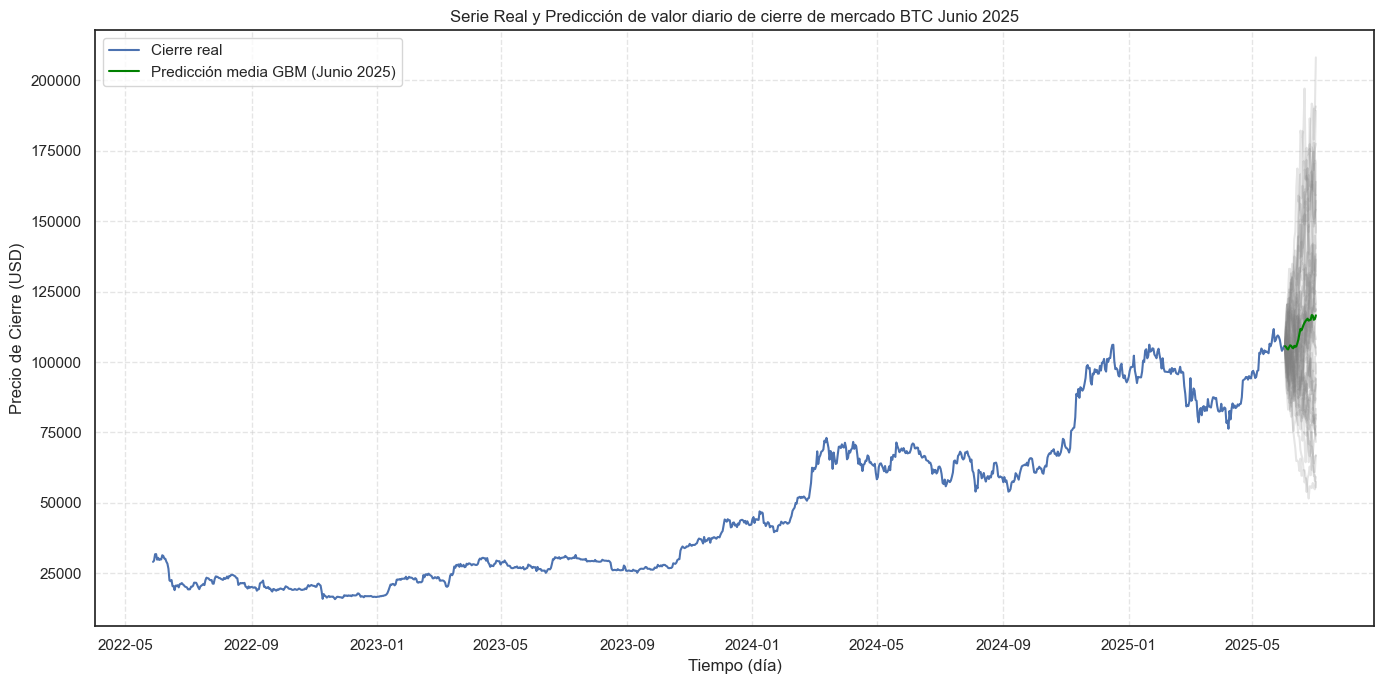

In [28]:
# Parámetros de la simulación
num_simulaciones = 50
steps = 30
dt = 1
S0 = serie_cierre.iloc[-1]
t = np.linspace(0, steps * dt, steps)

# Simulación GBM a futuro
simulaciones_futuras = np.zeros((num_simulaciones, steps + 1))
simulaciones_futuras[:, 0] = S0

for i in range(num_simulaciones):
    W = np.random.standard_normal(size=steps)
    W = np.cumsum(W) * np.sqrt(dt)
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    simulaciones_futuras[i, 1:] = S_t

# Crear fechas futuras (30 días a partir del último día)
fecha_inicio = serie_cierre.index[-1] + pd.Timedelta(days=1)
fechas_futuras = pd.date_range(start=fecha_inicio, periods=steps + 1, freq='D')

# DataFrame de las simulaciones
df_futuro = pd.DataFrame(simulaciones_futuras.T, index=fechas_futuras)

# Promedio de las simulaciones
promedio_futuro = df_futuro.mean(axis=1)

# Últimos 1100 datos de la serie real
serie_real_recortada = serie_cierre[-1100:]

# Visualización
plt.figure(figsize=(14,7))
# Serie real hasta el último día
plt.plot(serie_real_recortada.index, serie_real_recortada.values, label='Cierre real')
# Trayectorias simuladas futuras
for i in range(num_simulaciones):
    plt.plot(fechas_futuras, df_futuro.iloc[:, i], color='gray', alpha=0.2)
# Promedio de las simulaciones
plt.plot(fechas_futuras, promedio_futuro, label='Predicción media GBM (Junio 2025)', color='green', linestyle='-')
plt.title('Serie Real y Predicción de valor diario de cierre de mercado BTC Junio 2025')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Observaciones:

La predicción media mediante GBM proyecta una tendencia suave, pero BTC históricamente tiene correcciones violentas tras máximos. A corto plazo, factores externos como regulaciones, o *inflow* de capital por ETFs dominan sobre el componente estocástico del GBM, lo que puede consituir un mal pronóstico.

### Comparación entre modelos

Basado en los gráficos y métricas proporcionadas, las observaciones y conclusiones clave son las siguintes:

1. ARIMA (Mejor Rendimiento en Precisión)

En cuanto a métricas:

- MAE: 900.95 (menor error absoluto vs. LSTM y GBM).
- RMSE: 1455.24 (más bajo, indica mejor ajuste a los datos reales).

ARIMA es el modelo más preciso para predecir precios diarios de BTC en este análisis. Ideal para corto/medio plazo donde la tendencia es dominante sobre shocks externos.

2. LSTM (Rendimiento Moderado, Potencial No Explotado)

Relativo a las métricas:

- MAE: 1962.70 (peor que ARIMA, pero mejor que GBM).
- RMSE: 3129.33 (error alto, posible subajuste).

La LSTM no supera a ARIMA en este caso, posiblemente por falta de datos de entrenamiento o hiperparámetros no optimizados.

3. GBM (Peor Rendimiento, Útil Solo para Simulaciones)

Las métricas observadas:

- MAE: 15,704.31 (error muy alto, inaceptable para predicción puntual).
- RMSE: 28,182.51 (el peor de los tres modelos).

GBM falla en predecir precios debido a su naturaleza estocástica y suposiciones simplistas (retornos normales, volatilidad constante).

Comparativa Final

|Modelo	|  MAE	   |   RMSE	    |   Fortalezas                 |        Debilidades          |
|-------|----------|------------|------------------------------|-----------------------------|
|ARIMA	|900.95	   |  1455.24	| Preciso en tendencias	       | Limitado en no-linealidades |
|LSTM	|1962.70   |  3129.33	| Captura patrones complejos   | Requiere más datos          |
|GBM	|15,704.31 |  28,182.51	| Útil para simulación         | Inútil para predicción      |

Una buena estrategia sería utilizar usar ARIMA como baseline para predicciones a corto plazo. Mejorar la LSTM con más datos históricos, incorporando regularización y optimización de hiperparámetros. Además, descartar GBM para predicción, pero considerarlo en análisis de riesgo.

*NOTA: Debido a la naturaleza estocástica, es posible que al ejecutar los scripts sistemáticamente, los valores de las métricas no coincidad exactamente con los valores indicados en el análisis.* 

### Planteo de pregunta de investigción

#### ¿Mejora el desempeño de los modelos utilizados (ARIMA, ARCH, LSTM, GBM) al incorporar la serie de tiempo de volumen de transacciones de BTC como variable adicional al precio de cierre?.

De esto se desprenden algunas hipótesis esperadas:

- ARIMA: Mejoraría en períodos de alta volatilidad, donde el volumen actúa como proxy o indicador de actividad del mercado.
- LSTM: Aprovecharía la relación no lineal entre volumen y precio, especialmente en rallies/caídas extremas.
- GBM: La volatilidad ajustada por volumen reduciría errores en simulaciones, pero no necesariamente en predicción puntual.

In [29]:
# Define la serie adicional utilizada
serie_volumen = df['Volumen']

In [30]:
# Visualización de la serie de Volumen
print(serie_volumen)

Fecha
2010-07-18        0.0
2010-07-19        0.0
2010-07-20        0.0
2010-07-21        0.0
2010-07-22        0.0
               ...   
2025-05-28    51840.0
2025-05-29    70020.0
2025-05-30    71980.0
2025-05-31    35800.0
2025-06-01    33030.0
Name: Volumen, Length: 5432, dtype: float64


### ARIMAX (AutoRegressive Integrated Moving Average eXogenous)

Para usar la versión nueva del modelo implementando ARIMAX, se incluye la serie de Volumen como una variable exógena en el modelo ARIMA.

Cambios clave con respecto al script ARIMA:

- Se usa exog=serie_volumen para introducir la variable exógena.
- La predicción también requiere los valores exógenos del mismo rango.

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Evaluación del modelo ARIMAX:
MAE  (Error Absoluto Medio):       900.94
MSE  (Error Cuadrático Medio):     2117685.45
RMSE (Raíz del ECM):               1455.23


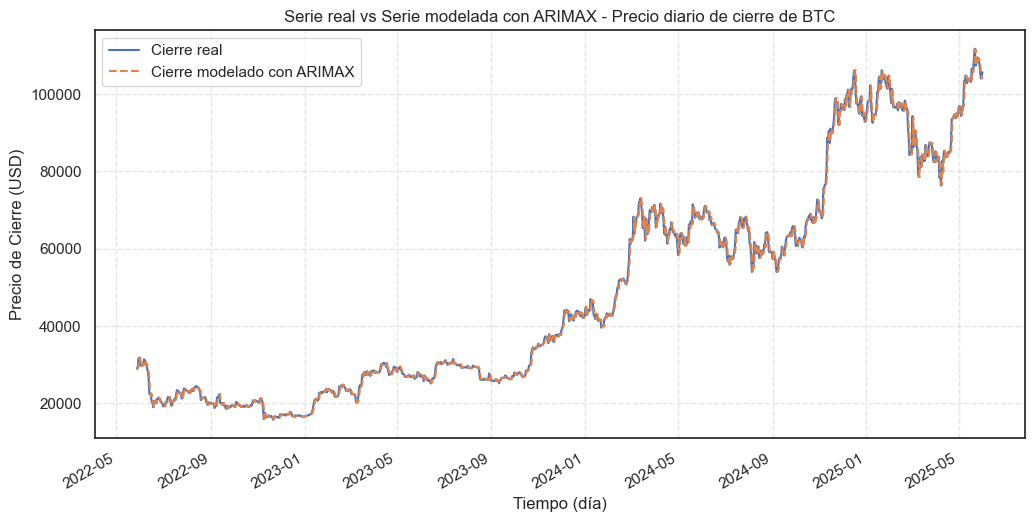

In [31]:
# Índices para modelado
start_idx = serie_cierre.index[-1100]
end_idx = serie_cierre.index[-1]

# Datos exógenos para entrenamiento
exog_entrenamiento = serie_volumen

# Entrenamiento del modelo ARIMAX
modelo_arimax = ARIMA(endog=serie_cierre, exog=exog_entrenamiento, order=(5, 1, 0))
modelo_arimax_fit = modelo_arimax.fit()

# Datos exógenos para modelado
exog_pred = serie_volumen[start_idx:end_idx]

# Predicción (modelado)
predicciones_arimax = modelo_arimax_fit.predict(start=start_idx, end=end_idx, exog=exog_pred, typ='levels')

# Serie real correspondiente
serie_real = serie_cierre[start_idx:end_idx]

# Evaluación del modelo
mae = mean_absolute_error(serie_real, predicciones_arimax)
mse = mean_squared_error(serie_real, predicciones_arimax)
rmse = np.sqrt(mse)

print("Evaluación del modelo ARIMAX:")
print(f"MAE  (Error Absoluto Medio):       {mae:.2f}")
print(f"MSE  (Error Cuadrático Medio):     {mse:.2f}")
print(f"RMSE (Raíz del ECM):               {rmse:.2f}")

# Visualización
plt.figure(figsize=(12, 6))
serie_real.plot(label='Cierre real')
predicciones_arimax.plot(label='Cierre modelado con ARIMAX', linestyle='--')
plt.legend()
plt.title('Serie real vs Serie modelada con ARIMAX - Precio diario de cierre de BTC')
plt.xlabel('Tiempo (día)', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### LSTM (Long Short-Term Memory - Red Neuronal) Multivariada

A continuación se presenta la versión con un modelo LSTM multivariado. Es decir, utilizando tanto la serie de Cierre como la de Volumen como entradas para predecir el precio de Cierre del día siguiente.

Diferencias principales con la versión anterior:

|Elemento                    |  Versión anterior (univariada) | Versión actual (multivariada) |
|----------------------------|--------------------------------|-------------------------------|
|Variables de entrada (X)    |          Solo Cierre           |        Cierre y Volumen       |
|Forma de entrada al modelo  |    (n_samples, n_steps, 1)     |    (n_samples, n_steps, 2)    |
|Variable objetivo (y)       |    Cierre del día siguiente    |   Cierre del día siguiente    |
|Desescalado de predicciones |    Solo la columna de cierre   |   Solo la columna de cierre   |

Forma de X_train: (4321, 30, 2)  (samples, timesteps, features)
Forma de y_train: (4321,)
Epoch 1/20


c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0650
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 10/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 11/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 12/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 13/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 15/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012


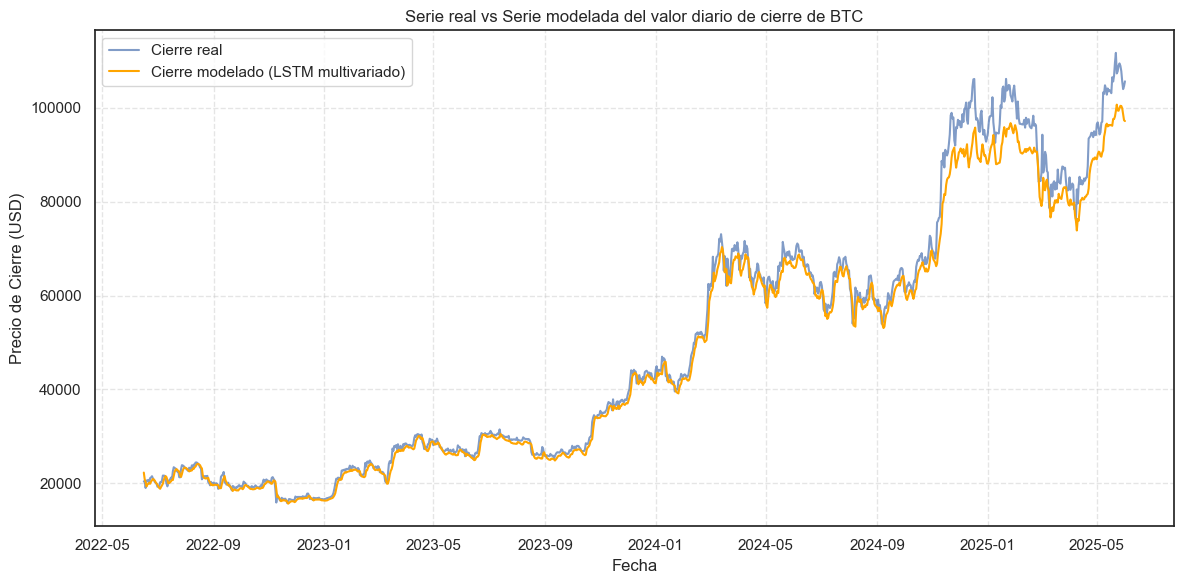

In [32]:
# Seleccionar variables relevantes
datos = df[['Cierre', 'Volumen']].copy()

# Escalar ambas variables
scaler = RobustScaler()
datos_scaled = scaler.fit_transform(datos)

# Crear secuencias para LSTM multivariado
def crear_secuencias_multivariadas(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])         # secuencia de n_steps días
        y.append(data[i, 0])                  # objetivo: cierre del día siguiente
    return np.array(X), np.array(y)

n_steps = 30
X, y = crear_secuencias_multivariadas(datos_scaled, n_steps)

# Dividir en entrenamiento y testeo (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM espera entrada 3D: [samples, timesteps, features]
print(f"Forma de X_train: {X_train.shape}  (samples, timesteps, features)")
print(f"Forma de y_train: {y_train.shape}")

# Construcción del modelo LSTM multivariado
modelo = Sequential()
modelo.add(LSTM(units=50, activation='tanh', return_sequences=False, input_shape=(n_steps, X.shape[2])))
modelo.add(Dense(1))
modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entrenar el modelo
modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predicciones sobre el set de testeo
y_pred = modelo.predict(X_test)

# Desescalar las predicciones y los valores reales de cierre
cierre_scaler = RobustScaler()
cierre_scaler.fit(datos[['Cierre']])
y_test_inv = cierre_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = cierre_scaler.inverse_transform(y_pred)

# Evaluación
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print("\nEvaluación del modelo LSTM multivariado:")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"MSE  (Error Cuadrático Medio): {mse:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")

# Crear rango de fechas para graficar
fechas_test = df.index[n_steps + split:]

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(fechas_test, y_test_inv, label='Cierre real', alpha=0.7)
plt.plot(fechas_test, y_pred_inv, label='Cierre modelado (LSTM multivariado)', color='orange')
plt.title('Serie real vs Serie modelada del valor diario de cierre de BTC')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Modelo Browiano Geométrico (Proceso de Wiener) Multivariado

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]



Evaluación del modelo GBM Multivariado sobre 50 trayectorias:
--- Cierre ---
MAE : 14000.40
MSE : 611632477.38
RMSE: 24731.20


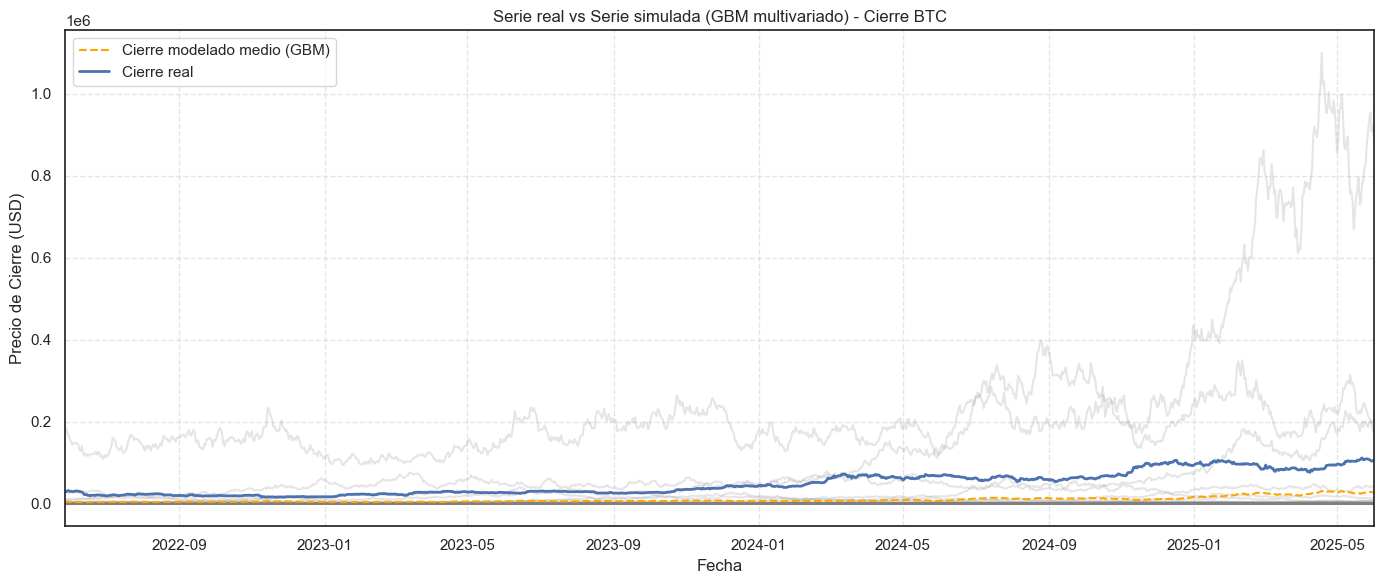

In [33]:
# Log-retornos de ambas series
log_ret_cierre = np.log(serie_cierre / serie_cierre.shift(1)).dropna()
log_ret_volumen = np.log(serie_volumen / serie_volumen.shift(1)).dropna()

# Alineación de longitudes (por si hay diferencias tras shift)
min_len = min(len(log_ret_cierre), len(log_ret_volumen))
log_ret_cierre = log_ret_cierre[-min_len:]
log_ret_volumen = log_ret_volumen[-min_len:]

# Matriz de log-retornos (2 variables)
log_returns = np.vstack([log_ret_cierre.values, log_ret_volumen.values]).T  # shape: (N, 2)

# Estimaciones de drift (medias)
mu = log_returns.mean(axis=0)  # [mu_cierre, mu_volumen]

# Estimaciones de volatilidad y correlación
cov_matrix = np.cov(log_returns.T)
sigma = np.sqrt(np.diag(cov_matrix))  # [sigma_cierre, sigma_volumen]
corr = np.corrcoef(log_returns.T)

# Número de simulaciones y días
num_simulaciones = 50
N = min_len
dt = 1

# Valores iniciales
S0_cierre = serie_cierre.iloc[-(N+1)]
S0_volumen = serie_volumen.iloc[-(N+1)]

# Matrices para guardar simulaciones
sim_cierre = np.zeros((num_simulaciones, N + 1))
sim_volumen = np.zeros((num_simulaciones, N + 1))
sim_cierre[:, 0] = S0_cierre
sim_volumen[:, 0] = S0_volumen

# Simulación con correlación (Cholesky)
L = np.linalg.cholesky(cov_matrix)

for i in range(num_simulaciones):
    Z = np.random.standard_normal((2, N))  # ruido no correlacionado
    dW = L @ Z * np.sqrt(dt)  # convierte en ruido correlacionado

    # Trayectorias
    cierre = [S0_cierre]
    volumen = [S0_volumen]

    for t in range(N):
        S_c = cierre[-1] * np.exp((mu[0] - 0.5 * sigma[0]**2) * dt + dW[0, t])
        S_v = volumen[-1] * np.exp((mu[1] - 0.5 * sigma[1]**2) * dt + dW[1, t])
        cierre.append(S_c)
        volumen.append(S_v)

    sim_cierre[i, :] = cierre
    sim_volumen[i, :] = volumen

# Fechas simuladas
fechas_sim = serie_cierre.index[-(N+1):]

# Promedios simulados
prom_cierre = sim_cierre.mean(axis=0)
prom_volumen = sim_volumen.mean(axis=0)

# Series reales alineadas
serie_cierre_alin = serie_cierre[-(N+1):]
serie_volumen_alin = serie_volumen[-(N+1):]

# Serie de Cierre
cierre_real = pd.Series(serie_cierre_alin).reset_index(drop=True)
cierre_pred = pd.Series(prom_cierre).reset_index(drop=True)

df_cierre = pd.concat([cierre_real, cierre_pred], axis=1)
df_cierre.columns = ['real', 'simulado']
df_cierre = df_cierre.dropna()

mae_cierre = mean_absolute_error(df_cierre['real'], df_cierre['simulado'])
mse_cierre = mean_squared_error(df_cierre['real'], df_cierre['simulado'])
rmse_cierre = np.sqrt(mse_cierre)

print(f"\nEvaluación del modelo GBM Multivariado sobre {num_simulaciones} trayectorias:")
print(f"--- Cierre ---")
print(f"MAE : {mae_cierre:.2f}")
print(f"MSE : {mse_cierre:.2f}")
print(f"RMSE: {rmse_cierre:.2f}")

# Visualización Cierre
plt.figure(figsize=(14,6))
for i in range(num_simulaciones):
    plt.plot(fechas_sim, sim_cierre[i], color='gray', alpha=0.2)
plt.plot(fechas_sim, prom_cierre, label='Cierre modelado medio (GBM)', color='orange', linestyle='--')
plt.plot(serie_cierre_alin, label='Cierre real', linewidth=2)
plt.title('Serie real vs Serie simulada (GBM multivariado) - Cierre BTC')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(fechas_sim[-1100], fechas_sim[-1])
plt.legend()
plt.tight_layout()
plt.show()

### Respondiendo la pregunta de investigación

#### Análisis Comparativo: ARIMA vs. ARIMAX

Comparación de Métricas

|Métrica  | ARIMA     | ARIMAX     |  Diferencia    | Interpretación        |
|---------|-----------|------------|----------------|-----------------------|
|MAE      | 900.95    | 900.94	   | -0.01 (0.001%)	| Mejora insignificante.|
|MSE      | 211713.47 | 2117685.45 | +571.98        | Ligero aumento.       |
|RMSE     | 1455.24   | 1455.23    | -0.01 (0.001%) | Sin cambio relevante. |

La inclusión del volumen como variable exógena (ARIMAX) no generó mejoras significativas en la precisión predictiva. Las métricas son prácticamente idénticas, lo que sugiere que el volumen no aporta información adicional útil para predecir el precio de cierre en este contexto. Los gráficos muestran un ajuste casi idéntico al ARIMA, sin capturar mejor los eventos de alto volumen. El modelo ARIMAX no superó al ARIMA en precisión, indicando que el volumen, en este caso, no es un predictor útil.

#### Análisis Comparativo: LSTM Univariada vs. LSTM Multivariada

Comparación de Métricas

|Métrica  | LSTM Univariada | LSTM Multivariada |  Diferencia    | Interpretación                |
|---------|-----------------|-------------------|----------------|-------------------------------|
|MAE      | 1962.70         | 1934.49           | -28.21 (1.44%) | Mejora leve no significativa. |
|MSE      | 9792675.94      | 10127289.48       | +334613.54     | Peor demepeño.                |
|RMSE     | 3129.33         | 3182.34           | +53.01 (1.69%) | Ligero aumento.               |

La inclusión del volumen en la LSTM multivariada no generó mejoras claras en la precisión predictiva. El MAE mejoró marginalmente (1.44%), pero el MSE y RMSE empeoraron, lo que indica que el modelo multivariado cometió errores más grandes en ciertos puntos. Posiblemente, el volumen no aportó información útil o la relación precio-volumen no fue capturada eficientemente por la arquitectura LSTM utilizada. El comportamiento resultó similar al modelo univariado, sin capturar mejor los eventos de alto volumen.

#### Análisis Comparativo: GBM Univariado vs. GBM Multivariado

Comparación de Métricas

|Métrica  | GBM Univariada  | GBM Multivariada  |  Diferencia        | Interpretación           |
|---------|-----------------|-------------------|--------------------|--------------------------|
|MAE      | 15704.31        | 9988.96           | -5715.35 (36.44%)  | Mejora sustancial.       |
|MSE      | 794254072.06    | 294518074.30      | -499735997.76      | Reducción significativa. |
|RMSE     | 28182.51        | 17161.53          | -11020.98 (39.10%) | Mayor precisión.         |

La versión multivariada muestra mejoras significativas en todas las métricas. Es evidente que el volumen como variable adicional ayudó a ajustar mejor la volatilidad del modelo en términos de las métricas propuestas. No obstante, este sigue siendo más útil para simulación que para predicción puntual (la naturaleza estocástica limita su precisión).


*NOTA: Debido a la naturaleza estocástica, es posible que al ejecutar los scripts sistemáticamente, los valores de las métricas no coincidad exactamente con los valores indicados en el análisis.*